C:\Users\iamchan\AppData\Local\Temp\ipykernel_1900\2157448219.py:6: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return 0.5 * (1.0 + np.vectorize(np.math.erf)(z / sqrt(2.0)))


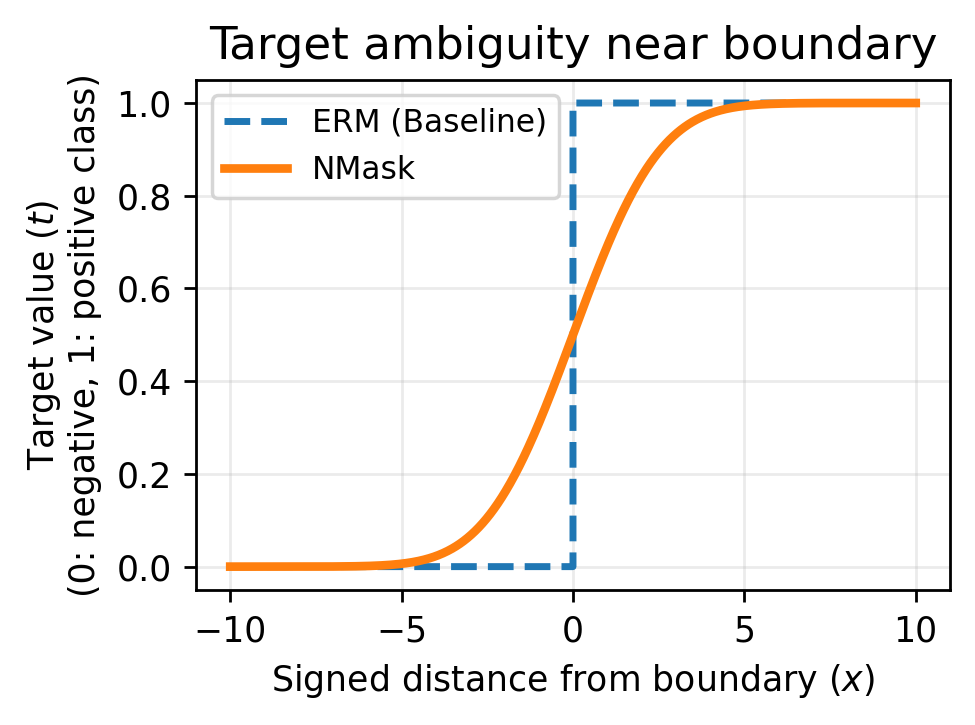

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

def normal_cdf(z: np.ndarray) -> np.ndarray:
    return 0.5 * (1.0 + np.vectorize(np.math.erf)(z / sqrt(2.0)))

# Parameters
x = np.linspace(-10, 10, 900)
boundary_pos = 0.0
sigma = 2.0

# Targets
t_erm = (x >= boundary_pos).astype(float)
t_nmask = normal_cdf((x - boundary_pos) / sigma)

# Plotting
plt.figure(figsize=(4, 3), dpi=250)
plt.step(x, t_erm, where='mid', linestyle='--', linewidth=2, label='ERM (Baseline)')
plt.plot(x, t_nmask, linewidth=2.5, label='NMask')

plt.ylabel(r'Target value ($t$)'+'\n(0: negative, 1: positive class)')
plt.title('Target ambiguity near boundary', fontsize=13)
plt.xlabel(r'Signed distance from boundary ($x$)')
plt.grid(alpha=0.25)
plt.legend(frameon=True, fontsize=9)

plt.tight_layout()
plt.savefig("Fig3-a.svg", bbox_inches="tight")
plt.show()

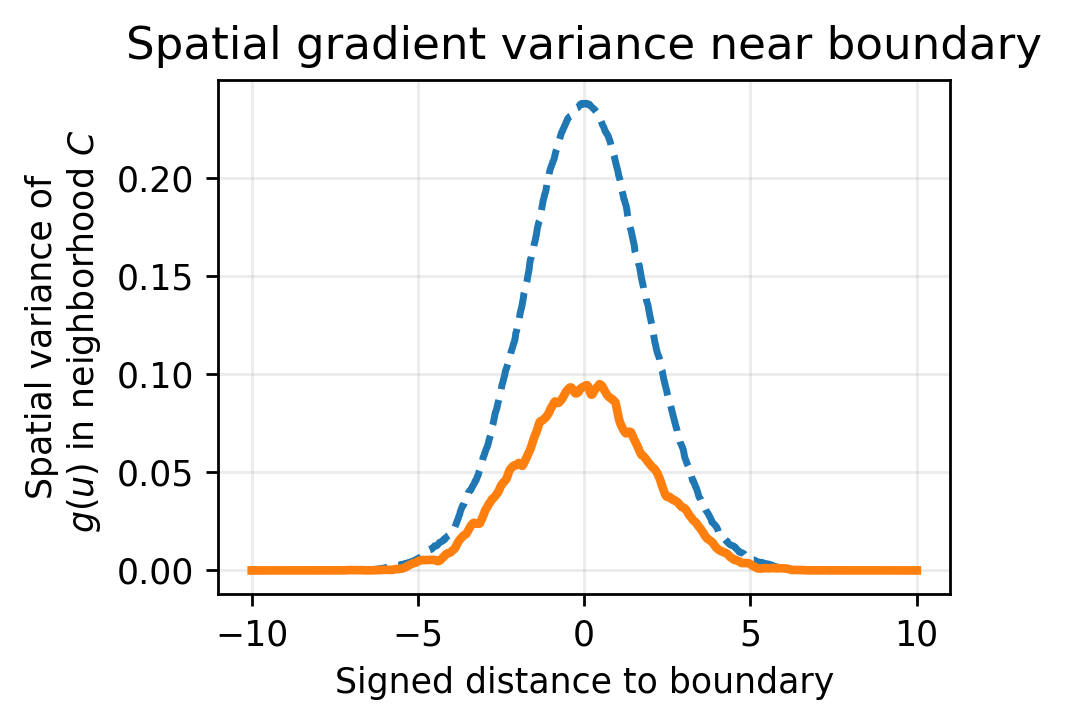

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# Helpers
# -----------------------
def gaussian_kernel1d(sigma: float, radius: int | None = None) -> np.ndarray:
    if radius is None:
        radius = int(3 * sigma)
    x = np.arange(-radius, radius + 1)
    k = np.exp(-(x**2) / (2 * sigma**2))
    return k / (k.sum() + 1e-12)

def smooth1d(arr: np.ndarray, sigma_pix: float) -> np.ndarray:
    k = gaussian_kernel1d(sigma_pix)
    return np.convolve(arr, k, mode="same")

def local_variance(arr: np.ndarray, win: int) -> np.ndarray:
    """Population variance within a sliding window of size win."""
    assert win % 2 == 1, "win must be odd"
    pad = win // 2
    a = np.pad(arr, (pad, pad), mode="edge")
    out = np.zeros_like(arr, dtype=float)
    for i in range(len(arr)):
        w = a[i : i + win]
        m = w.mean()
        out[i] = ((w - m) ** 2).mean()
    return out

# -----------------------
# Parameters (for proof-aligned surrogate)
# -----------------------
x = np.linspace(-10, 10, 900)   # 1D signed distance axis
N = len(x)

pred_const = 0.5                # fixed prediction (matches "equal prediction" assumption)
sigma_delta = 2.0               # marginal std of boundary displacement
trials = 1000                    # Monte-Carlo trials to estimate expectation
win = 21                        # neighborhood |C| (odd window size)
smooth_sigma_pix = 8.0          # smoothness of displacement field for NMask (in pixels)
seed = 7
rng = np.random.default_rng(seed)

# -----------------------
# Compute expected local spatial variance v_spat(C(x))
# -----------------------
v_erm_acc = np.zeros(N)
v_nmask_acc = np.zeros(N)

for _ in range(trials):
    # (ERM surrogate) high-frequency / uncorrelated displacement field:
    # delta(x) are i.i.d -> Cov(eta(u), eta(v)) ~ 0 for u != v
    delta_iid = rng.normal(0.0, sigma_delta, size=N)
    T_erm = (x >= delta_iid).astype(float)      # binary per-position target sample
    g_erm = pred_const - T_erm                  # logit-gradient surrogate
    v_erm_acc += local_variance(g_erm, win)

    # (NMask surrogate) spatially smooth / correlated displacement field:
    # delta(x) is a smoothed random field -> positive correlation among neighbors
    noise = rng.normal(0.0, 1.0, size=N)
    delta_smooth = smooth1d(noise, smooth_sigma_pix)
    # normalize to match marginal std with ERM case (fair comparison of covariance effect)
    delta_smooth -= delta_smooth.mean()
    delta_smooth = delta_smooth / (delta_smooth.std() + 1e-12) * sigma_delta

    T_nm = (x >= delta_smooth).astype(float)    # binary per-position target sample
    g_nm = pred_const - T_nm
    v_nmask_acc += local_variance(g_nm, win)

v_erm = v_erm_acc / trials
v_nmask = v_nmask_acc / trials

# -----------------------
# Plot
# -----------------------
plt.figure(figsize=(4, 3), dpi=250)
plt.plot(x, v_erm, linestyle="--", linewidth=2.0, label="ERM")
plt.plot(x, v_nmask, linewidth=2.5, label="NMask")

plt.xlabel("Signed distance to boundary")
plt.ylabel("Spatial variance of\n $g(u)$ in neighborhood $C$")
plt.title("Spatial gradient variance near boundary", fontsize=13)
plt.grid(alpha=0.25)
plt.tight_layout()
plt.savefig("Fig3-c.svg", bbox_inches="tight")
plt.show()


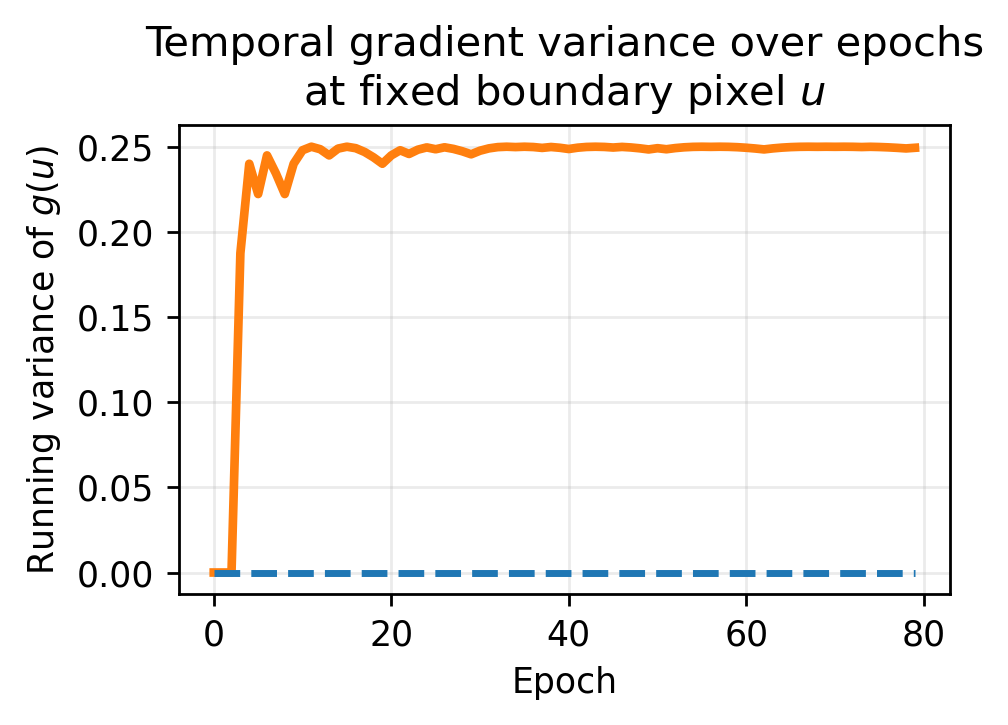

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def running_variance_population(arr: np.ndarray) -> np.ndarray:
    """
    Running (population) variance:
        Var_t = (1/t) * sum_{e=1..t} (g_e - mean_t)^2
    """
    out = np.zeros_like(arr, dtype=float)
    for t in range(1, len(arr) + 1):
        m = arr[:t].mean()
        out[t - 1] = ((arr[:t] - m) ** 2).mean()
    return out

# -----------------------
# Parameters
# -----------------------
EPOCHS = 80
x0 = 0.0          # fixed location near boundary
k = 1.0
eps = 2.0         # boundary jitter range (Uniform)
seed = 7
rng = np.random.default_rng(seed)

# Fixed prediction (isolate target effect)
pred0 = sigmoid(k * x0)

# ERM: deterministic target at x0 (convention: t=1 for x>=0)
t0_erm = 1.0 if x0 >= 0 else 0.0
g_erm = np.full(EPOCHS, pred0 - t0_erm)  # constant over epochs -> variance 0

# NMask: stochastic target via boundary shift delta_e ~ Uniform(-eps, eps)
delta = rng.uniform(-eps, eps, size=EPOCHS)
t0 = (x0 >= delta).astype(float)
g_nmask = pred0 - t0

# Running variances
rv_erm = running_variance_population(g_erm)
rv_nmask = running_variance_population(g_nmask)

# -----------------------
# Plot
# -----------------------
plt.figure(figsize=(4, 3), dpi=250)
plt.plot(rv_nmask, linewidth=2.5, label="NMask", color='#FF7F0E')
plt.plot(rv_erm, linestyle="--", linewidth=2.0, label="ERM")

plt.xlabel("Epoch")
plt.ylabel(r"Running variance of $g(u)$")
plt.title(r"Temporal gradient variance over epochs" + "\n" + r"at fixed boundary pixel $u$")
plt.grid(alpha=0.25)
# plt.legend(frameon=True, fontsize=9)
plt.tight_layout()

out_pdf = "Fig3-b.svg"
plt.savefig(out_pdf, bbox_inches="tight")
plt.show()
